In [1]:
!git clone https://github.com/sdatta97/imcbbrrepro

Cloning into 'imcbbrrepro'...
remote: Enumerating objects: 25284, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 25284 (delta 145), reused 172 (delta 88), pack-reused 25043
Receiving objects: 100% (25284/25284), 80.60 MiB | 24.79 MiB/s, done.
Resolving deltas: 100% (24169/24169), done.
Updating files: 100% (23204/23204), done.


In [2]:
!cp imcbbrrepro/data/re-when-to-use-bbr-415-Sep6-ffund_00417771374.15.0-191-generic_cubic_bbr.tgz /content/
!cp imcbbrrepro/data/re-when-to-use-bbr-513-Sep6-ffund_00417771375.13.12_cubic_bbr2.tgz /content/
!cp imcbbrrepro/data/original_result_imc_bbr.csv /content/

In [ ]:
!tar -xzf re-when-to-use-bbr-415-Sep6-ffund_00417771374.15.0-191-generic_cubic_bbr.tgz
!tar -xzf re-when-to-use-bbr-513-Sep6-ffund_00417771375.13.12_cubic_bbr2.tgz

In [ ]:
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
from matplotlib.colors import LogNorm, Normalize
import numpy as np

In [ ]:
exp_factors = {
    'bufcap': [100, 10000],
    'bandwidth': [10, 20, 50, 100, 250, 500, 750, 1000],
    'rtt': [5, 10, 25, 50, 75, 100, 150, 200],
    'cc': ["cubic", "bbr"],
    'trial': [2, 3, 4, 5]
}


In [ ]:
exp_factors2 = {
    'bufcap': [100, 10000],
    'bandwidth': [10, 20, 50, 100, 250, 500, 750, 1000],
    'rtt': [5, 10, 25, 50, 75, 100, 150, 200],
    'cc': ["cubic", "bbr2"],
    'trial': [2, 3, 4, 5]
}


In [ ]:
exp = '4.15.0-191-generic_cubic_bbr'
kernel = exp.split('_')[0].split('-')[0]

In [ ]:
exp2 = '5.13.12_cubic_bbr2'
kernel2 = exp2.split('_')[0]

In [ ]:
!cd /content/{exp}; grep 'Kbits/sec.*receiver' *.txt > /content/tput-all.txt
!awk -F'[_ .]' '{print $1","$2","$3","$4","$5","$21}' /content/tput-all.txt > /content/tput.csv
!cd /content/{exp}; grep 'Kbits/sec.*sender' *.txt > /content/retx-all.txt
!awk -F'[_ .]' '{print $1","$2","$3","$4","$5","$24}' /content/retx-all.txt > /content/retx.csv

In [ ]:
!cd /content/{exp2}; grep 'Kbits/sec.*receiver' *.txt > /content/tput-all2.txt
!awk -F'[_ .]' '{print $1","$2","$3","$4","$5","$21}' /content/tput-all2.txt > /content/tput2.csv
!cd /content/{exp2}; grep 'Kbits/sec.*sender' *.txt > /content/retx-all2.txt
!awk -F'[_ .]' '{print $1","$2","$3","$4","$5","$24}' /content/retx-all2.txt > /content/retx2.csv

In [ ]:
df_original = pd.read_csv("original_result_imc_bbr.csv")

## Shallow buffer

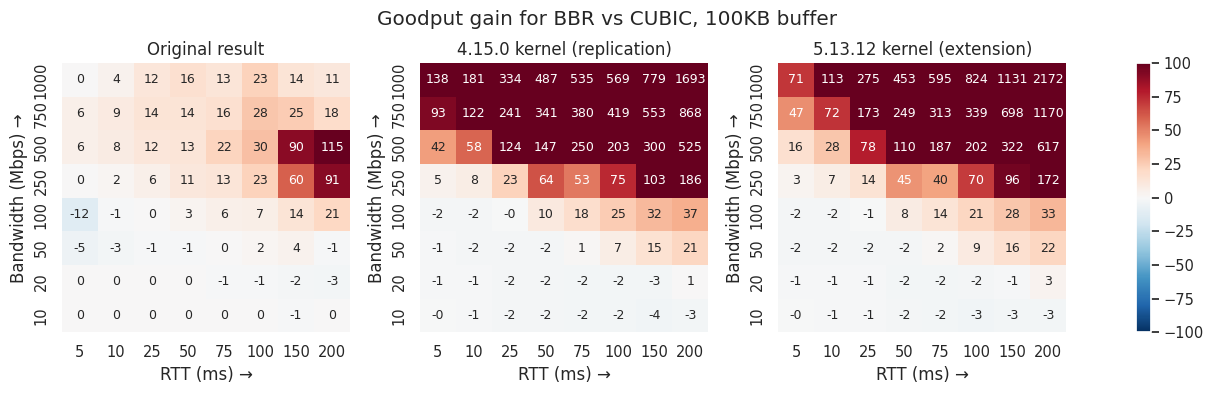

In [ ]:
matplotlib.rc('xtick', labelsize=10.5)
matplotlib.rc('ytick', labelsize=10.5)


fig, (ax1, ax2, ax3, cax) = plt.subplots(nrows=1, ncols=4, figsize=(12.3,4),  gridspec_kw={"width_ratios":[1, 1, 1, 0.05]})
sns.set(font_scale=1)


dat_hm = df_original[df_original.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="goodput_gain")
sns.heatmap(dat_hm, ax=ax1, annot=True, fmt=".0f", cmap="RdBu_r", center=0, vmin=-100, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax1.invert_yaxis()
ax1.set_title("\nOriginal result")
ax1.set_xlabel("RTT (ms) →")
ax1.set_ylabel("Bandwidth (Mbps) →")

df_tput = pd.read_csv('tput.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
# force it to drop bad runs
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(goodput_gain = 100*(df_tput['goodput_' + exp_factors['cc'][1]]-df_tput['goodput_' + exp_factors['cc'][0]])/df_tput['goodput_' + exp_factors['cc'][0]])


dat_hm = df_tput[df_tput.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="goodput_gain")
sns.heatmap(dat_hm, ax=ax2, annot=True, fmt=".0f", cmap="RdBu_r", center=0, vmin=-100, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax2.invert_yaxis()
ax2.set_title("\n" + kernel + " kernel (replication)")
ax2.set_xlabel("RTT (ms) →")
ax2.set_ylabel("Bandwidth (Mbps) →")


df_tput2 = pd.read_csv('tput2.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
# force it to drop bad runs
df_tput2['goodput_'] = pd.to_numeric(df_tput2['goodput_'], errors='coerce').dropna()
df_tput2 = df_tput2.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput2.columns = [''.join(col).strip() for col in df_tput2.columns.values]
df_tput2 = df_tput2.assign(goodput_gain = 100*(df_tput2['goodput_' + exp_factors2['cc'][1]]-df_tput['goodput_' + exp_factors2['cc'][0]])/df_tput2['goodput_' + exp_factors['cc'][0]])


dat_hm2 = df_tput2[df_tput2.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="goodput_gain")
sns.heatmap(dat_hm2, ax=ax3, annot=True, fmt=".0f", cmap="RdBu_r", center=0, vmin=-100, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax3.invert_yaxis()
ax3.set_title("\n" + kernel2 + " kernel (extension)")
ax3.set_xlabel("RTT (ms) →")
ax3.set_ylabel("Bandwidth (Mbps) →")

# colorbar
fig.colorbar(ax1.get_children()[0], cax=cax)


plt.tight_layout()
plt.suptitle("Goodput gain for " + exp_factors['cc'][1].upper() + " vs " + exp_factors['cc'][0].upper() + ", 100KB buffer\n");

plt.savefig("gpgain-shallow.pdf")
plt.show();


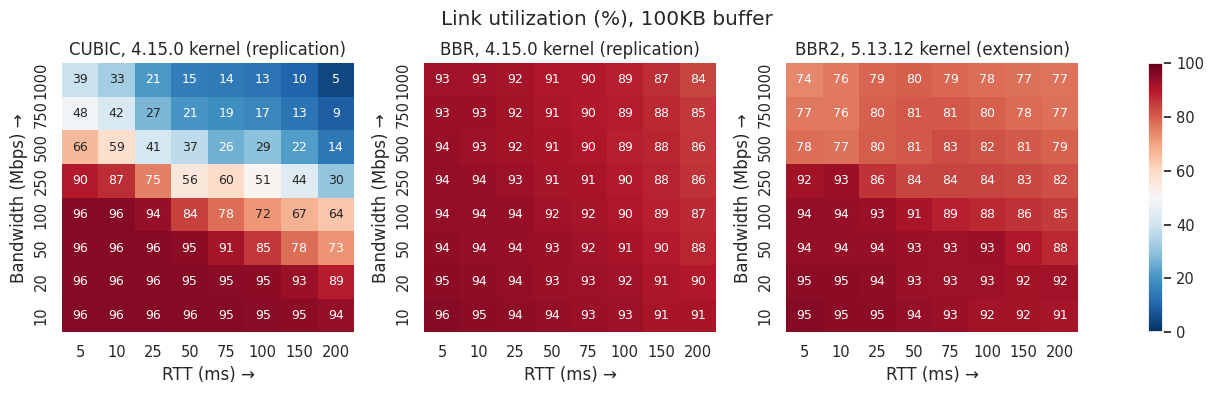

In [ ]:
matplotlib.rc('xtick', labelsize=10.5)
matplotlib.rc('ytick', labelsize=10.5)


fig, (ax1, ax2, ax3, cax) = plt.subplots(nrows=1, ncols=4, figsize=(12.3,4),  gridspec_kw={"width_ratios":[1, 1, 1, 0.05]})
sns.set(font_scale=1)


df_tput = pd.read_csv('tput.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['cc'][0] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm, ax=ax1, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax1.invert_yaxis()
ax1.set_title("\n" + exp_factors['cc'][0].upper()  + ", " + kernel + " kernel (replication)")
ax1.set_xlabel("RTT (ms) →")
ax1.set_ylabel("Bandwidth (Mbps) →")



df_tput = pd.read_csv('tput.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['cc'][1] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm, ax=ax2, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax2.invert_yaxis()
ax2.set_title("\n" + exp_factors['cc'][1].upper()  + ", " + kernel + " kernel (replication)")
ax2.set_xlabel("RTT (ms) →")
ax2.set_ylabel("Bandwidth (Mbps) →")


df_tput2 = pd.read_csv('tput2.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput2['goodput_'] = pd.to_numeric(df_tput2['goodput_'], errors='coerce').dropna()
df_tput2 = df_tput2.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput2.columns = [''.join(col).strip() for col in df_tput2.columns.values]
df_tput2 = df_tput2.assign(util = 100*(df_tput2['goodput_' + exp_factors2['cc'][1] ]/(df_tput2['bandwidth']*1000)))
dat_hm2 = df_tput2[df_tput2.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm2, ax=ax3, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax3.invert_yaxis()
ax3.set_title("\n" + exp_factors2['cc'][1].upper()  + ", " + kernel2 + " kernel (extension)")
ax3.set_xlabel("RTT (ms) →")
ax3.set_ylabel("Bandwidth (Mbps) →")

# colorbar
fig.colorbar(ax1.get_children()[0], cax=cax)


plt.tight_layout()
plt.suptitle("Link utilization (%), 100KB buffer\n");

plt.savefig("util-shallow.pdf")
plt.show();


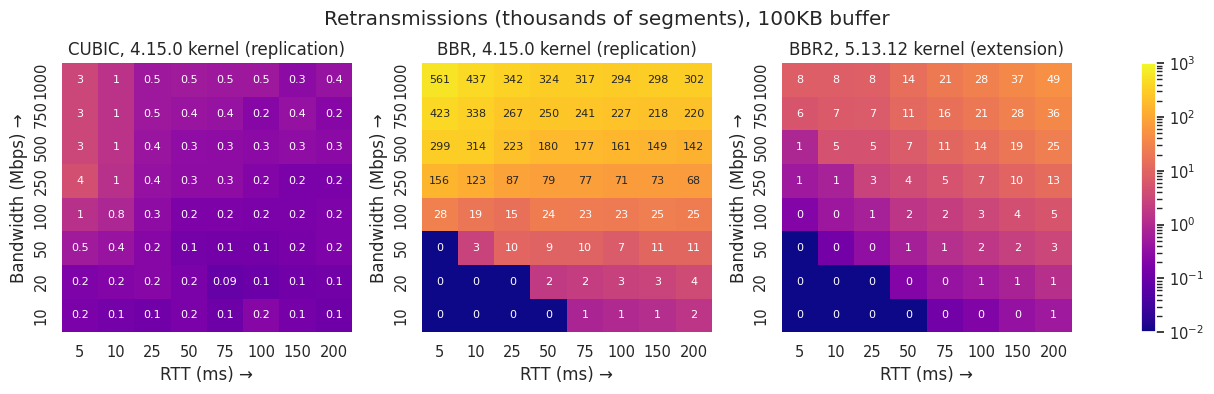

In [ ]:
matplotlib.rc('xtick', labelsize=10.5)
matplotlib.rc('ytick', labelsize=10.5)


fig, (ax1, ax2, ax3, cax) = plt.subplots(nrows=1, ncols=4, figsize=(12.3,4),  gridspec_kw={"width_ratios":[1, 1, 1, 0.05]})
sns.set(font_scale=1)


df_retx = pd.read_csv('retx.csv', names = ['bufcap','bandwidth','rtt','trial','cc','retx_'])
df_retx = df_retx.fillna(0)
df_retx = df_retx.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['retx_'], aggfunc='mean').reset_index()
df_retx.columns = [''.join(col).strip() for col in df_retx.columns.values]
df_retx = df_retx.assign(util = df_retx['retx_' + exp_factors['cc'][0] ]/1000 + 0.0001)
dat_hm = df_retx[df_retx.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm, ax=ax1, annot=True, fmt=".1g", cmap="plasma", norm=LogNorm(0.01, 1000), cbar=False, annot_kws={"fontsize":8})
ax1.invert_yaxis()
ax1.set_title("\n" + exp_factors['cc'][0].upper()  + ", " + kernel + " kernel (replication)")
ax1.set_xlabel("RTT (ms) →")
ax1.set_ylabel("Bandwidth (Mbps) →")



df_retx = pd.read_csv('retx.csv', names = ['bufcap','bandwidth','rtt','trial','cc','retx_'])
df_retx = df_retx.fillna(0)
df_retx = df_retx.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['retx_'], aggfunc='mean').reset_index()
df_retx.columns = [''.join(col).strip() for col in df_retx.columns.values]
df_retx = df_retx.assign(util = df_retx['retx_' + exp_factors['cc'][1] ]/1000 + 0.0001)
dat_hm = df_retx[df_retx.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm, ax=ax2, annot=True, fmt=".0f", cmap="plasma", norm=LogNorm(0.01, 1000), cbar=False, annot_kws={"fontsize":8})
ax2.invert_yaxis()
ax2.set_title("\n" + exp_factors['cc'][1].upper()  + ", " + kernel + " kernel (replication)")
ax2.set_xlabel("RTT (ms) →")
ax2.set_ylabel("Bandwidth (Mbps) →")


df_retx2 = pd.read_csv('retx2.csv', names = ['bufcap','bandwidth','rtt','trial','cc','retx_'])
df_retx2 = df_retx2.fillna(0)
df_retx2 = df_retx2.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['retx_'], aggfunc='mean').reset_index()
df_retx2.columns = [''.join(col).strip() for col in df_retx2.columns.values]
df_retx2 = df_retx2.assign(util = df_retx2['retx_' + exp_factors2['cc'][1] ]/1000 + 0.0001)
dat_hm2 = df_retx2[df_retx2.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm2, ax=ax3, annot=True, fmt=".0f", cmap="plasma", norm=LogNorm(0.01, 1000), cbar=False, annot_kws={"fontsize":8})
ax3.invert_yaxis()
ax3.set_title("\n" + exp_factors2['cc'][1].upper()  + ", " + kernel2 + " kernel (extension)")
ax3.set_xlabel("RTT (ms) →")
ax3.set_ylabel("Bandwidth (Mbps) →")

# colorbar
fig.colorbar(ax1.get_children()[0], cax=cax)


plt.tight_layout()
plt.suptitle("Retransmissions (thousands of segments), 100KB buffer\n");

plt.savefig("retx-shallow.pdf")
plt.show();


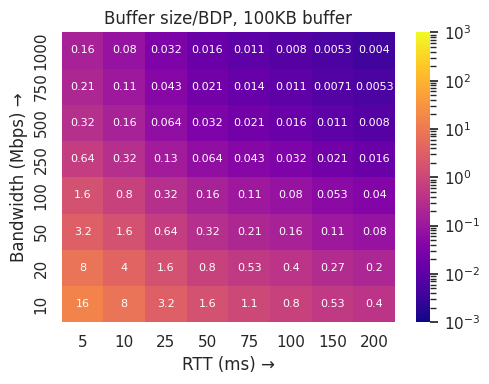

In [ ]:
plt.figure(figsize=(5.1,4))

df_tput = pd.read_csv('tput.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['bdp'] = (df_tput.bandwidth*1e6)*(df_tput.rtt*1e-3)
df_tput['buffer'] = df_tput.bufcap*8000/df_tput['bdp']
df_tput = df_tput.pivot_table(index=['bufcap','bandwidth','rtt'], values=['buffer', 'bdp'], aggfunc='mean').reset_index()
dat_hm = df_tput[df_tput.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="buffer")
sns.set(font_scale=1)
ax = sns.heatmap(dat_hm, annot=True, fmt=".2g", cmap="plasma", norm=LogNorm(0.001, 1000), cbar=True, annot_kws={"fontsize":8})
ax.invert_yaxis()
ax.set_title("Buffer size/BDP, 100KB buffer")
plt.xlabel("RTT (ms) →")
plt.ylabel("Bandwidth (Mbps) →")

plt.tight_layout()
plt.savefig("bdp-shallow.pdf")
plt.show();


## Deep buffers

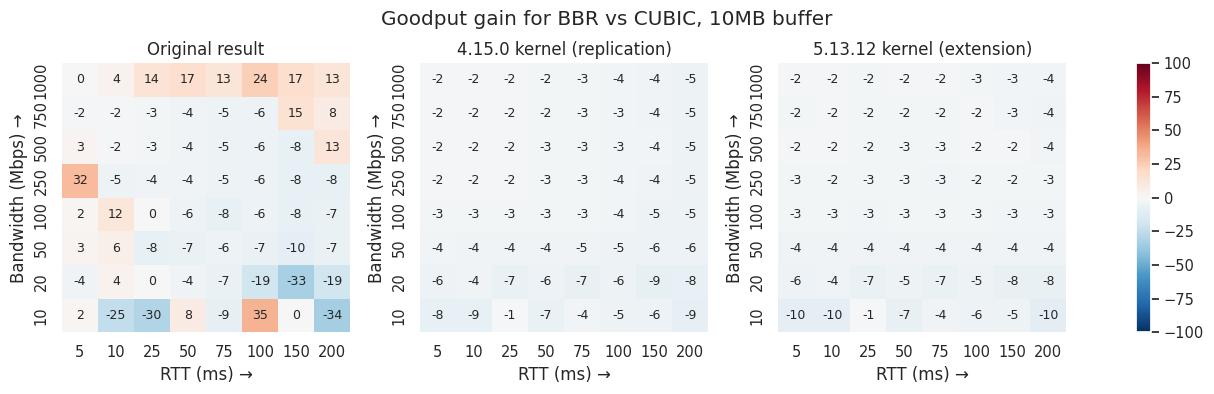

In [ ]:
matplotlib.rc('xtick', labelsize=10.5)
matplotlib.rc('ytick', labelsize=10.5)


fig, (ax1, ax2, ax3, cax) = plt.subplots(nrows=1, ncols=4, figsize=(12.3,4),  gridspec_kw={"width_ratios":[1, 1, 1, 0.05]})
sns.set(font_scale=1)


dat_hm = df_original[df_original.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="goodput_gain")
sns.heatmap(dat_hm, ax=ax1, annot=True, fmt=".0f", cmap="RdBu_r", center=0, vmin=-100, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax1.invert_yaxis()
ax1.set_title("\nOriginal result")
ax1.set_xlabel("RTT (ms) →")
ax1.set_ylabel("Bandwidth (Mbps) →")

df_tput = pd.read_csv('tput.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
# force it to drop bad runs
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(goodput_gain = 100*(df_tput['goodput_' + exp_factors['cc'][1]]-df_tput['goodput_' + exp_factors['cc'][0]])/df_tput['goodput_' + exp_factors['cc'][0]])


dat_hm = df_tput[df_tput.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="goodput_gain")
sns.heatmap(dat_hm, ax=ax2, annot=True, fmt=".0f", cmap="RdBu_r", center=0, vmin=-100, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax2.invert_yaxis()
ax2.set_title("\n" + kernel + " kernel (replication)")
ax2.set_xlabel("RTT (ms) →")
ax2.set_ylabel("Bandwidth (Mbps) →")


df_tput2 = pd.read_csv('tput2.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
# force it to drop bad runs
df_tput2['goodput_'] = pd.to_numeric(df_tput2['goodput_'], errors='coerce').dropna()
df_tput2 = df_tput2.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput2.columns = [''.join(col).strip() for col in df_tput2.columns.values]
df_tput2 = df_tput2.assign(goodput_gain = 100*(df_tput2['goodput_' + exp_factors2['cc'][1]]-df_tput['goodput_' + exp_factors2['cc'][0]])/df_tput2['goodput_' + exp_factors['cc'][0]])


dat_hm2 = df_tput2[df_tput2.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="goodput_gain")
sns.heatmap(dat_hm2, ax=ax3, annot=True, fmt=".0f", cmap="RdBu_r", center=0, vmin=-100, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax3.invert_yaxis()
ax3.set_title("\n" + kernel2 + " kernel (extension)")
ax3.set_xlabel("RTT (ms) →")
ax3.set_ylabel("Bandwidth (Mbps) →")

# colorbar
fig.colorbar(ax1.get_children()[0], cax=cax)


plt.tight_layout()
plt.suptitle("Goodput gain for " + exp_factors['cc'][1].upper() + " vs " + exp_factors['cc'][0].upper() + ", 10MB buffer\n");

plt.savefig("gpgain-deep.pdf")
plt.show();


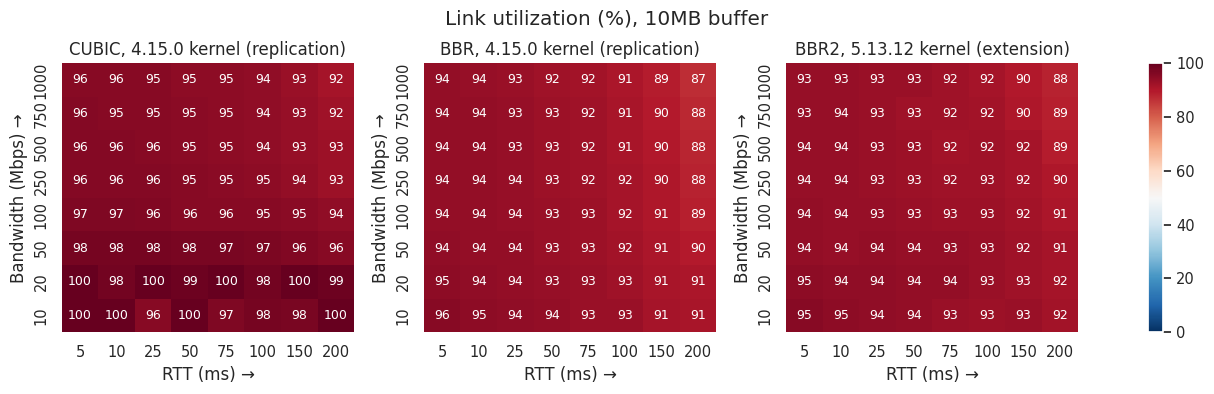

In [ ]:
matplotlib.rc('xtick', labelsize=10.5)
matplotlib.rc('ytick', labelsize=10.5)


fig, (ax1, ax2, ax3, cax) = plt.subplots(nrows=1, ncols=4, figsize=(12.3,4),  gridspec_kw={"width_ratios":[1, 1, 1, 0.05]})
sns.set(font_scale=1)


df_tput = pd.read_csv('tput.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = np.clip(100*(df_tput['goodput_' + exp_factors['cc'][0] ]/(df_tput['bandwidth']*1000)), 0, 100))
dat_hm = df_tput[df_tput.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm, ax=ax1, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax1.invert_yaxis()
ax1.set_title("\n" + exp_factors['cc'][0].upper()  + ", " + kernel + " kernel (replication)")
ax1.set_xlabel("RTT (ms) →")
ax1.set_ylabel("Bandwidth (Mbps) →")



df_tput = pd.read_csv('tput.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['cc'][1] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm, ax=ax2, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax2.invert_yaxis()
ax2.set_title("\n" + exp_factors['cc'][1].upper()  + ", " + kernel + " kernel (replication)")
ax2.set_xlabel("RTT (ms) →")
ax2.set_ylabel("Bandwidth (Mbps) →")


df_tput2 = pd.read_csv('tput2.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput2['goodput_'] = pd.to_numeric(df_tput2['goodput_'], errors='coerce').dropna()
df_tput2 = df_tput2.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index()
df_tput2.columns = [''.join(col).strip() for col in df_tput2.columns.values]
df_tput2 = df_tput2.assign(util = 100*(df_tput2['goodput_' + exp_factors2['cc'][1] ]/(df_tput2['bandwidth']*1000)))
dat_hm2 = df_tput2[df_tput2.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm2, ax=ax3, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100, cbar=False, annot_kws={"fontsize":9})
ax3.invert_yaxis()
ax3.set_title("\n" + exp_factors2['cc'][1].upper()  + ", " + kernel2 + " kernel (extension)")
ax3.set_xlabel("RTT (ms) →")
ax3.set_ylabel("Bandwidth (Mbps) →")

# colorbar
fig.colorbar(ax1.get_children()[0], cax=cax)


plt.tight_layout()
plt.suptitle("Link utilization (%), 10MB buffer\n");

plt.savefig("util-deep.pdf")
plt.show();


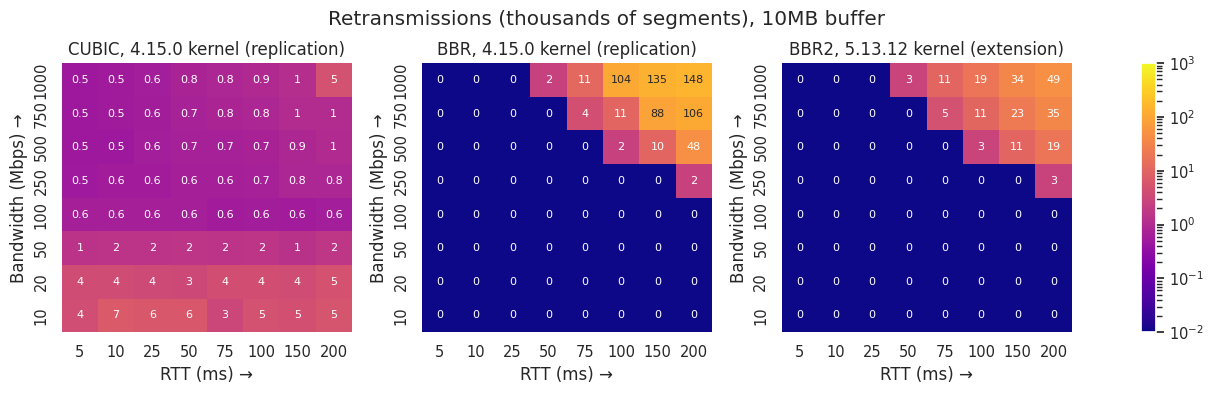

In [ ]:
matplotlib.rc('xtick', labelsize=10.5)
matplotlib.rc('ytick', labelsize=10.5)


fig, (ax1, ax2, ax3, cax) = plt.subplots(nrows=1, ncols=4, figsize=(12.3,4),  gridspec_kw={"width_ratios":[1, 1, 1, 0.05]})
sns.set(font_scale=1)


df_retx = pd.read_csv('retx.csv', names = ['bufcap','bandwidth','rtt','trial','cc','retx_'])
df_retx = df_retx.fillna(0)
df_retx = df_retx.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['retx_'], aggfunc='mean').reset_index()
df_retx.columns = [''.join(col).strip() for col in df_retx.columns.values]
df_retx = df_retx.assign(util = df_retx['retx_' + exp_factors['cc'][0] ]/1000 + 0.0001)
dat_hm = df_retx[df_retx.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm, ax=ax1, annot=True, fmt=".1g", cmap="plasma", norm=LogNorm(0.01, 1000), cbar=False, annot_kws={"fontsize":8})
ax1.invert_yaxis()
ax1.set_title("\n" + exp_factors['cc'][0].upper()  + ", " + kernel + " kernel (replication)")
ax1.set_xlabel("RTT (ms) →")
ax1.set_ylabel("Bandwidth (Mbps) →")



df_retx = pd.read_csv('retx.csv', names = ['bufcap','bandwidth','rtt','trial','cc','retx_'])
df_retx = df_retx.fillna(0)
df_retx = df_retx.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['retx_'], aggfunc='mean').reset_index()
df_retx.columns = [''.join(col).strip() for col in df_retx.columns.values]
df_retx = df_retx.assign(util = df_retx['retx_' + exp_factors['cc'][1] ]/1000 + 0.0001)
dat_hm = df_retx[df_retx.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm, ax=ax2, annot=True, fmt=".0f", cmap="plasma", norm=LogNorm(0.01, 1000), cbar=False, annot_kws={"fontsize":8})
ax2.invert_yaxis()
ax2.set_title("\n" + exp_factors['cc'][1].upper()  + ", " + kernel + " kernel (replication)")
ax2.set_xlabel("RTT (ms) →")
ax2.set_ylabel("Bandwidth (Mbps) →")


df_retx2 = pd.read_csv('retx2.csv', names = ['bufcap','bandwidth','rtt','trial','cc','retx_'])
df_retx2 = df_retx2.fillna(0)
df_retx2 = df_retx2.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['retx_'], aggfunc='mean').reset_index()
df_retx2.columns = [''.join(col).strip() for col in df_retx2.columns.values]
df_retx2 = df_retx2.assign(util = df_retx2['retx_' + exp_factors2['cc'][1] ]/1000 + 0.0001)
dat_hm2 = df_retx2[df_retx2.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.heatmap(dat_hm2, ax=ax3, annot=True, fmt=".0f", cmap="plasma", norm=LogNorm(0.01, 1000), cbar=False, annot_kws={"fontsize":8})
ax3.invert_yaxis()
ax3.set_title("\n" + exp_factors2['cc'][1].upper()  + ", " + kernel2 + " kernel (extension)")
ax3.set_xlabel("RTT (ms) →")
ax3.set_ylabel("Bandwidth (Mbps) →")

# colorbar
fig.colorbar(ax1.get_children()[0], cax=cax)


plt.tight_layout()
plt.suptitle("Retransmissions (thousands of segments), 10MB buffer\n");

plt.savefig("retx-deep.pdf")
plt.show();


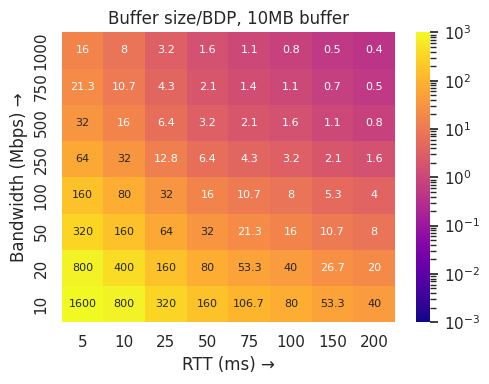

In [ ]:
plt.figure(figsize=(5.1,4))

df_tput = pd.read_csv('tput.csv', names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['bdp'] = (df_tput.bandwidth*1e6)*(df_tput.rtt*1e-3)
df_tput['buffer'] = np.round(df_tput.bufcap*8000/df_tput['bdp'], 1)
df_tput = df_tput.pivot_table(index=['bufcap','bandwidth','rtt'], values=['buffer', 'bdp'], aggfunc='mean').reset_index()
dat_hm = df_tput[df_tput.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="buffer")
sns.set(font_scale=1)
ax = sns.heatmap(dat_hm, annot=True, fmt=".4g", cmap="plasma", norm=LogNorm(0.001, 1000), cbar=True, annot_kws={"fontsize":8})
ax.invert_yaxis()
ax.set_title("Buffer size/BDP, 10MB buffer")
plt.xlabel("RTT (ms) →")
plt.ylabel("Bandwidth (Mbps) →")

plt.tight_layout()
plt.savefig("bdp-deep.pdf")
plt.show();
